<a href="https://colab.research.google.com/github/choiking10/ML-tutorial/blob/main/mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

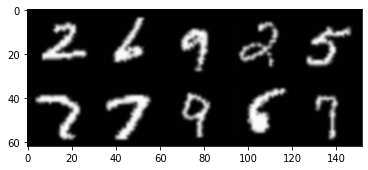

In [24]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters

latent_size = 64
hidden_size = 256
image_size = 784

num_epochs = 200
batch_size = 100
smaple_dir = 'samples'

if not os.path.exists(smaple_dir):
  os.makedirs(sample_dir)

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5])                              
])

mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                           batch_size=batch_size,
                                           shuffle=True)

def show_image(tensor_images, size=10, nrow=5):
  to_pil = transforms.ToPILImage()
  grid_img = torchvision.utils.make_grid(tensor_images[:size], nrow=nrow)
  plt.imshow(to_pil(grid_img), interpolation="bicubic")

for i, (images, _) in enumerate(data_loader):
  show_image(images)
  break

